- plot ensemble accuracy scaling med størrelse 
- find ud af om der er leak af data for test/validation under træning
- få accuracy af de enkle modeller
- kig på om der er noget preproccesing af datasettet
- start med student har samme arkitæktur som ensemble
- Modellen overfitter da vi mangler test labels

# Embed dataset:

In [42]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import lightgbm as lgb


In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Paths to save/load embeddings and labels
train_embeddings_file = 'train_embeddings.npy'
train_labels_file = 'train_labels.npy'
validation_embeddings_file = 'validation_embeddings.npy'
validation_labels_file = 'validation_labels.npy'
test_embeddings_file = 'test_embeddings.npy'
test_labels_file = 'test_labels.npy'

# Check if embeddings and labels are already saved
if (os.path.exists(train_embeddings_file) and os.path.exists(train_labels_file) and
    os.path.exists(validation_embeddings_file) and os.path.exists(validation_labels_file) and
    os.path.exists(test_embeddings_file) and os.path.exists(test_labels_file)):
    # Load embeddings and labels
    train_embeddings = np.load(train_embeddings_file)
    train_labels = np.load(train_labels_file)
    validation_embeddings = np.load(validation_embeddings_file)
    validation_labels = np.load(validation_labels_file)
    test_embeddings = np.load(test_embeddings_file)
    test_labels = np.load(test_labels_file)
    print("Loaded train, validation, and test embeddings and labels from disk.")
else:
    # Load model directly
    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")
    model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")

    # Move the model to GPU
    model = model.to(device)

    # Load the SST-2 dataset from the GLUE benchmark with streaming
    dataset = load_dataset('glue', 'sst2', streaming=True)

    # Initialize lists to store embeddings and labels for each set
    train_embeddings_list = []
    train_labels_list = []
    validation_embeddings_list = []
    validation_labels_list = []
    test_embeddings_list = []
    test_labels_list = []

    # Function to extract embeddings
    def extract_embeddings(streamed_dataset, embeddings_list, labels_list):
        for example in tqdm(streamed_dataset):
            inputs = tokenizer(
                example['sentence'],
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # last layer hidden states
            embeddings = hidden_states.mean(dim=1).cpu().numpy()  # average over sequence length
            embeddings_list.append(embeddings.squeeze())  # shape (hidden_size,)
            labels_list.append(example['label'])

    # Extract embeddings for train, validation, and test sets
    extract_embeddings(dataset['train'], train_embeddings_list, train_labels_list)
    extract_embeddings(dataset['validation'], validation_embeddings_list, validation_labels_list)
    extract_embeddings(dataset['test'], test_embeddings_list, test_labels_list)

    # Convert lists to numpy arrays
    train_embeddings = np.vstack(train_embeddings_list)
    train_labels = np.array(train_labels_list)
    validation_embeddings = np.vstack(validation_embeddings_list)
    validation_labels = np.array(validation_labels_list)
    test_embeddings = np.vstack(test_embeddings_list)
    test_labels = np.array(test_labels_list)

    # Standardize the embeddings
    scaler = StandardScaler()
    train_embeddings = scaler.fit_transform(train_embeddings)
    validation_embeddings = scaler.transform(validation_embeddings)
    test_embeddings = scaler.transform(test_embeddings)

    # Save embeddings, labels, and scaler to disk
    np.save(train_embeddings_file, train_embeddings)
    np.save(train_labels_file, train_labels)
    np.save(validation_embeddings_file, validation_embeddings)
    np.save(validation_labels_file, validation_labels)
    np.save(test_embeddings_file, test_embeddings)
    np.save(test_labels_file, test_labels)

    print("Saved train, validation, and test embeddings and labels to disk.")

# Print shapes of embeddings and labels
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation embeddings shape: {validation_embeddings.shape}")
print(f"Validation labels shape: {validation_labels.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Test labels shape: {test_labels.shape}")

Using device: cuda
Loaded train, validation, and test embeddings and labels from disk.
Train embeddings shape: (67349, 2048)
Train labels shape: (67349,)
Validation embeddings shape: (872, 2048)
Validation labels shape: (872,)
Test embeddings shape: (1821, 2048)
Test labels shape: (1821,)


# Ensemble training

In [68]:
# Define the MLP architecture
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x  

# Hyperparameters
ensemble_size = 10
input_size = train_embeddings.shape[1]
hidden_sizes = 2048
output_size = 2
num_epochs = 100
batch_size = 1024
learning_rate = 0.0001
weight_decay = 1e-4

# Create an ensemble of MLPs
ensemble = [MLPClassifier(input_size, hidden_sizes, output_size).to(device) for _ in range(ensemble_size)]

# Split training data into new training and stacking (meta-training) sets
X_train_new, X_meta, y_train_new, y_meta = train_test_split(
    train_embeddings, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Convert to tensors
X_train_new_tensor = torch.tensor(X_train_new, dtype=torch.float32).to(device)
y_train_new_tensor = torch.tensor(y_train_new, dtype=torch.long).to(device)
X_meta_tensor = torch.tensor(X_meta, dtype=torch.float32).to(device)
y_meta_tensor = torch.tensor(y_meta, dtype=torch.long).to(device)
validation_embeddings_tensor = torch.tensor(validation_embeddings, dtype=torch.float32).to(device)
validation_labels_tensor = torch.tensor(validation_labels, dtype=torch.long).to(device)

# Prepare criterion and optimizer for each model
criterions = [nn.CrossEntropyLoss() for _ in ensemble]
optimizers = [optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) for model in ensemble]
schedulers = [optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) for optimizer in optimizers]

# Lists to store losses and accuracies
model_training_losses = [[] for _ in ensemble]
model_validation_losses = [[] for _ in ensemble]
model_training_accuracies = [[] for _ in ensemble]
model_validation_accuracies = [[] for _ in ensemble]

# Training the base models on new training set
num_samples = X_train_new_tensor.size(0)
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Shuffle the data
    permutation = torch.randperm(num_samples)
    X_train_shuffled = X_train_new_tensor[permutation]
    y_train_shuffled = y_train_new_tensor[permutation]
    
    epoch_loss = [0.0 for _ in ensemble]
    
    # Split into batches
    for i in range(0, num_samples, batch_size):
        batch_embeddings = X_train_shuffled[i:i+batch_size]
        batch_labels = y_train_shuffled[i:i+batch_size]
        
        # For each model in ensemble
        for idx, model in enumerate(ensemble):
            model.train()
            optimizer = optimizers[idx]
            criterion = criterions[idx]
            
            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            model_training_losses[idx].append(loss.item())
            
            epoch_loss[idx] += loss.item()
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == batch_labels).float().mean().item()
            model_training_accuracies[idx].append(accuracy)
    
    # After epoch, evaluate each model on stacking set
    for idx, model in enumerate(ensemble):
        model.eval()
        with torch.no_grad():
            outputs = model(X_meta_tensor)
            val_loss = criterions[idx](outputs, y_meta_tensor).item()
            model_validation_losses[idx].append(val_loss)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_meta_tensor).float().mean().item()
            model_validation_accuracies[idx].append(accuracy)
            print(f"Model {idx+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy*100:.2f}%")
            # Step the scheduler
            schedulers[idx].step(val_loss)

# Generate base model predictions on stacking set (X_meta)
meta_features = []
for idx, model in enumerate(ensemble):
    model.eval()
    with torch.no_grad():
        outputs = model(X_meta_tensor)
        probs = nn.functional.softmax(outputs, dim=1)  # Get probabilities
        # Use either probabilities or logits as features
        meta_features.append(probs.cpu().numpy())

# Stack the features
meta_features = np.hstack(meta_features)  # Shape: (num_samples, ensemble_size * num_classes)



Epoch 1/100
Model 1, Validation Loss: 0.3012, Validation Accuracy: 87.16%
Model 2, Validation Loss: 0.3006, Validation Accuracy: 87.22%
Model 3, Validation Loss: 0.3013, Validation Accuracy: 87.10%
Model 4, Validation Loss: 0.3020, Validation Accuracy: 87.21%
Model 5, Validation Loss: 0.3002, Validation Accuracy: 87.33%
Model 6, Validation Loss: 0.3024, Validation Accuracy: 87.22%
Model 7, Validation Loss: 0.2996, Validation Accuracy: 87.28%
Model 8, Validation Loss: 0.3036, Validation Accuracy: 87.20%
Model 9, Validation Loss: 0.3016, Validation Accuracy: 87.29%
Model 10, Validation Loss: 0.3006, Validation Accuracy: 87.37%

Epoch 2/100
Model 1, Validation Loss: 0.2747, Validation Accuracy: 88.52%
Model 2, Validation Loss: 0.2741, Validation Accuracy: 88.63%
Model 3, Validation Loss: 0.2749, Validation Accuracy: 88.51%
Model 4, Validation Loss: 0.2752, Validation Accuracy: 88.53%
Model 5, Validation Loss: 0.2743, Validation Accuracy: 88.59%
Model 6, Validation Loss: 0.2753, Validatio

In [112]:
# Train the meta-model
meta_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    n_estimators=200,
    reg_lambda=0.1,
    learning_rate=0.01,
    num_leaves=200,
    max_depth=10,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=50
)
meta_model.fit(meta_features, y_meta)

# Generate base model predictions on validation set
validation_meta_features = []
for idx, model in enumerate(ensemble):
    model.eval()
    with torch.no_grad():
        outputs = model(validation_embeddings_tensor)
        probs = nn.functional.softmax(outputs, dim=1)
        validation_meta_features.append(probs.cpu().numpy())

# Stack the features
validation_meta_features = np.hstack(validation_meta_features)

# Predict using the meta-model
validation_preds = meta_model.predict(validation_meta_features)
validation_probs = meta_model.predict_proba(validation_meta_features)[:, 1]  # Probability of positive class
validation_accuracy = accuracy_score(validation_labels, validation_preds)
print(f"\nStacked Ensemble Validation Accuracy: {validation_accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(validation_labels, validation_preds, target_names=['Negative', 'Positive']))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(validation_labels, validation_preds))

# Evaluate the base ensemble (without stacking) for comparison
# Generate average probabilities from base models
ensemble_outputs = torch.zeros((validation_embeddings_tensor.size(0), output_size)).to(device)
for model in ensemble:
    model.eval()
    with torch.no_grad():
        outputs = model(validation_embeddings_tensor)
        probs = nn.functional.softmax(outputs, dim=1)
        ensemble_outputs += probs

ensemble_outputs /= ensemble_size  # Average the probabilities
_, ensemble_predicted = torch.max(ensemble_outputs, 1)
ensemble_accuracy = (ensemble_predicted.cpu() == validation_labels_tensor.cpu()).float().mean().item()
print(f"\nBase Ensemble Validation Accuracy: {ensemble_accuracy * 100:.2f}%")

[LightGBM] [Info] Number of positive: 7514, number of negative: 5956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 13470, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557832 -> initscore=0.232369
[LightGBM] [Info] Start training from score 0.232369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Base Ensemble Validation Loss: 0.4355

Stacked Ensemble Validation Accuracy: 86.93%
Expected Calibration Error (ECE): 36.02%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87       428
    Positive       0.87      0.88      0.87       444

    accuracy                           0.87       872
   macro avg       0.87      0.87      0.87       872
weighted avg       0.87      0.87      0.87       872


Confusion Matrix:
[[368  60]
 [ 54 390]]


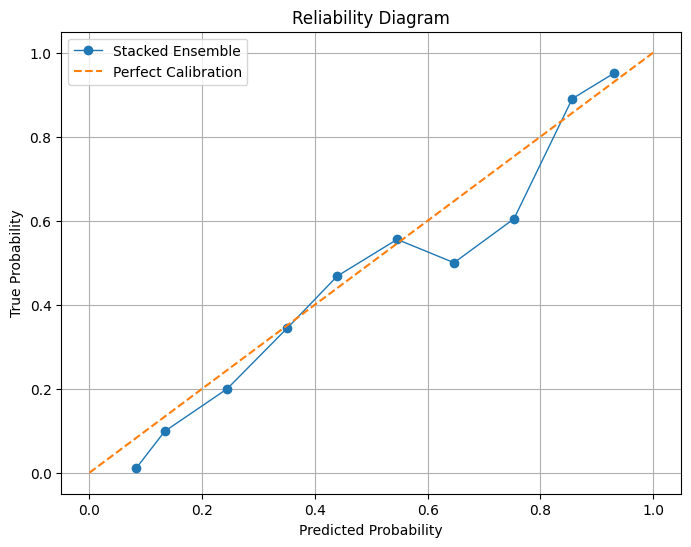

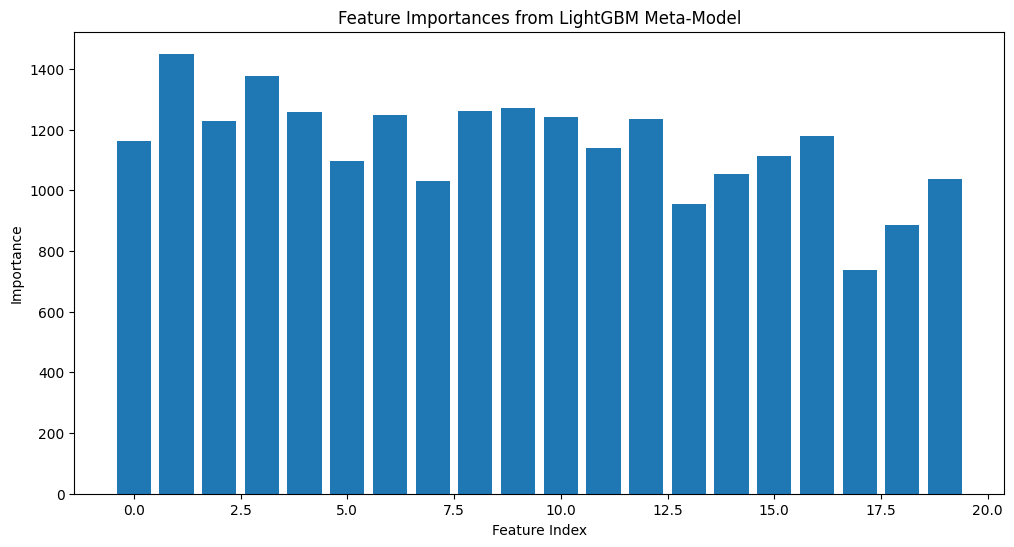

In [113]:
# Negative log likelihood loss
ensemble_loss = nn.functional.cross_entropy(ensemble_outputs, validation_labels_tensor)
print(f"Base Ensemble Validation Loss: {ensemble_loss.item():.4f}")

# Expected calibration error
def compute_ece(y_true, y_probs, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).
    
    Parameters:
    - y_true: True labels (numpy array of shape (n_samples,))
    - y_probs: Predicted probabilities for the positive class (numpy array of shape (n_samples,))
    - n_bins: Number of bins to use for calibration
    
    Returns:
    - ece: Expected Calibration Error
    """
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(y_probs, bin_edges, right=True) - 1  # Bin indices start from 0

    ece = 0.0
    for i in range(n_bins):
        # Indices of samples in bin i
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            # Average confidence in bin i
            avg_confidence_in_bin = np.mean(y_probs[bin_mask])
            # Average accuracy in bin i
            avg_accuracy_in_bin = np.mean(y_true[bin_mask] == (y_probs[bin_mask] >= 0.5))
            # Proportion of samples in bin i
            prop_in_bin = bin_size / y_probs.shape[0]
            # Accumulate ECE
            ece += np.abs(avg_confidence_in_bin - avg_accuracy_in_bin) * prop_in_bin
    return ece

# Accuracy
validation_accuracy = accuracy_score(validation_labels, validation_preds)
print(f"\nStacked Ensemble Validation Accuracy: {validation_accuracy * 100:.2f}%")

# Expected Calibration Error
ece = compute_ece(validation_labels, validation_probs, n_bins=10)
print(f"Expected Calibration Error (ECE): {ece * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(validation_labels, validation_preds, target_names=['Negative', 'Positive']))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(validation_labels, validation_preds))

# Compute calibration curve
prob_true, prob_pred = calibration_curve(validation_labels, validation_probs, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Stacked Ensemble')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Reliability Diagram')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid()
plt.show()

# Get feature importances
feature_importances = meta_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from LightGBM Meta-Model')
plt.show()

In [92]:
# Calibrate the model using the meta set
calibrated_meta_model = CalibratedClassifierCV(estimator=meta_model, method='isotonic', cv='prefit')
calibrated_meta_model.fit(validation_meta_features, validation_labels)

# Predict probabilities with the calibrated model
validation_probs_calibrated = calibrated_meta_model.predict_proba(validation_meta_features)[:, 1]

# Recalculate ECE
ece_calibrated = compute_ece(validation_labels, validation_probs_calibrated, n_bins=10)
print(f"Calibrated Expected Calibration Error (ECE): {ece_calibrated * 100:.2f}%")

Calibrated Expected Calibration Error (ECE): 20.99%


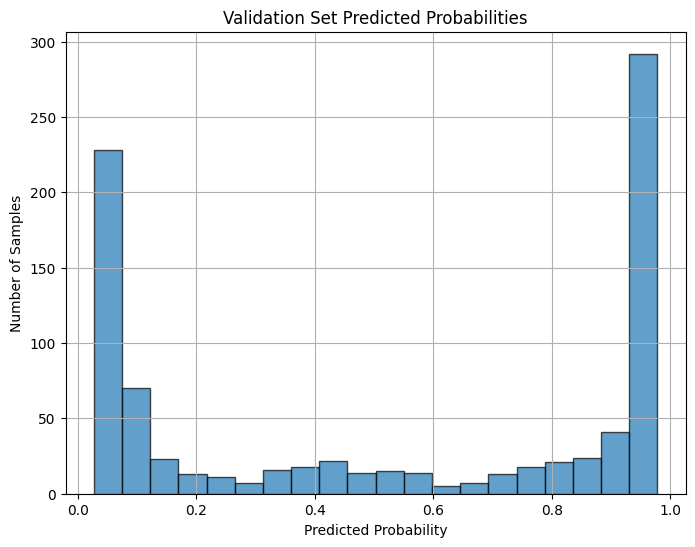

In [72]:
def plot_predicted_probabilities(y_probs, title='Predicted Probabilities Histogram'):
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.grid(True)
    plt.show()

# For validation set probabilities
plot_predicted_probabilities(validation_probs, title='Validation Set Predicted Probabilities')


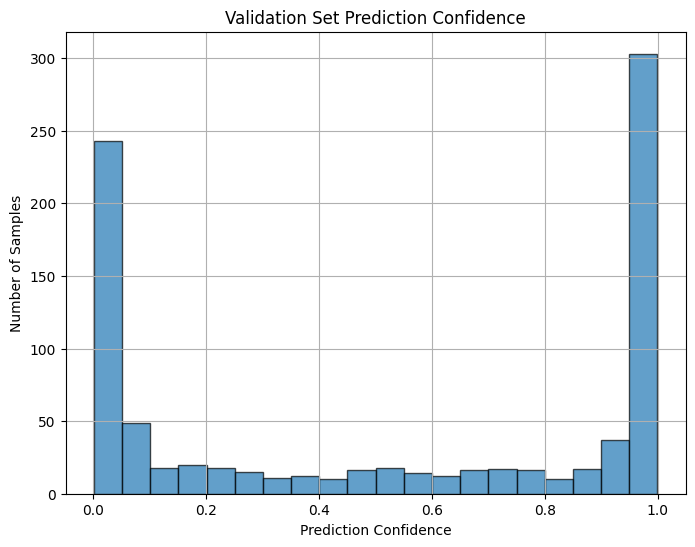

In [49]:
def plot_prediction_confidence(y_probs, title='Prediction Confidence Histogram'):
    # For binary classification, y_probs is sufficient
    confidence = y_probs
    plt.figure(figsize=(8, 6))
    plt.hist(confidence, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.grid(True)
    plt.show()

# For validation set probabilities
plot_prediction_confidence(validation_probs, title='Validation Set Prediction Confidence')


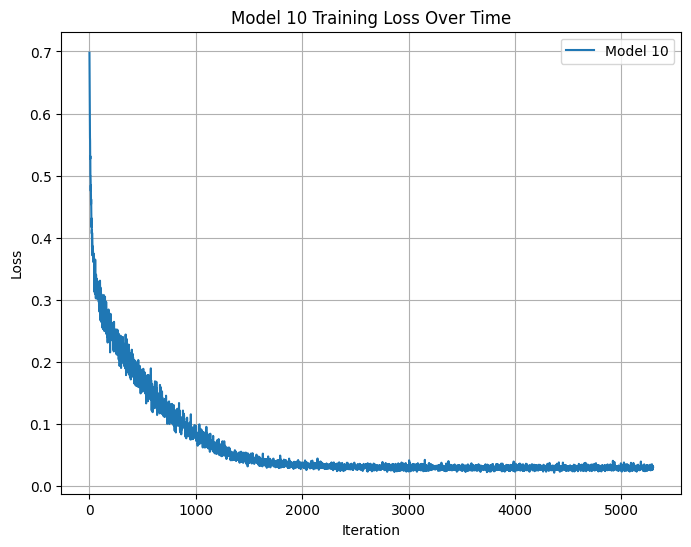

In [51]:
def plot_model_training_losses(model_losses, model_index):
    plt.figure(figsize=(8, 6))
    plt.plot(model_losses, label=f'Model {model_index + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Model {model_index + 1} Training Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot training losses for the first model
plot_model_training_losses(model_training_losses[9], model_index=9)


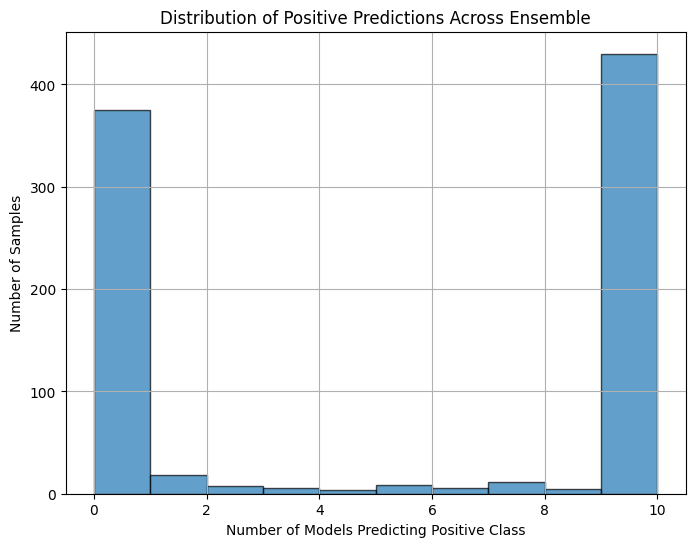

In [52]:
def plot_base_model_predictions(ensemble, X_data, y_true, sample_size=1000):
    import random
    num_models = len(ensemble)
    # Randomly select a subset of samples if data is large
    indices = random.sample(range(X_data.size(0)), min(sample_size, X_data.size(0)))
    X_sample = X_data[indices]
    y_true_sample = y_true[indices].cpu().numpy()
    
    predictions = []
    for idx, model in enumerate(ensemble):
        model.eval()
        with torch.no_grad():
            outputs = model(X_sample)
            probs = nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            predictions.append(preds)
    
    predictions = np.array(predictions)  # Shape: (num_models, num_samples)
    
    # For each class, count the number of models predicting that class for each sample
    counts = np.sum(predictions == 1, axis=0)  # Assuming class '1' is positive
    
    plt.figure(figsize=(8, 6))
    plt.hist(counts, bins=range(0, num_models + 1), edgecolor='k', alpha=0.7)
    plt.xlabel('Number of Models Predicting Positive Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Positive Predictions Across Ensemble')
    plt.grid(True)
    plt.show()
    
# Example usage
plot_base_model_predictions(ensemble, validation_embeddings_tensor, validation_labels_tensor)


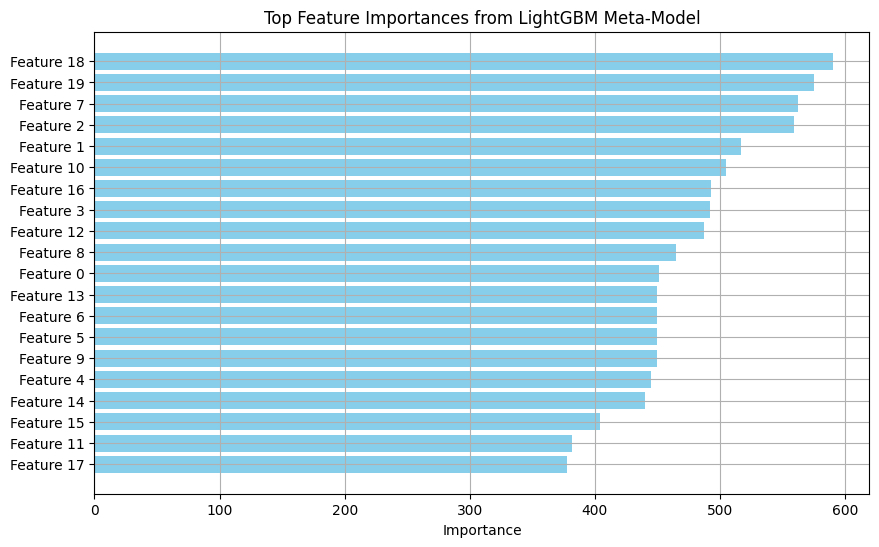

In [53]:
def plot_feature_importances(meta_model, num_top_features=20):
    import pandas as pd
    importances = meta_model.feature_importances_
    feature_indices = np.argsort(importances)[::-1][:num_top_features]
    sorted_importances = importances[feature_indices]
    feature_names = [f'Feature {i}' for i in feature_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[::-1], sorted_importances[::-1], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top Feature Importances from LightGBM Meta-Model')
    plt.grid(True)
    plt.show()

# Plot top 20 feature importances
plot_feature_importances(meta_model, num_top_features=20)


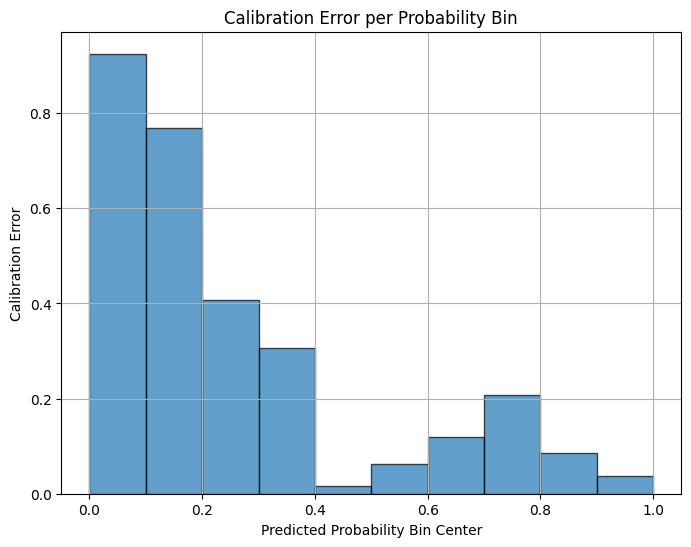

In [54]:
def plot_calibration_error_per_bin(y_true, y_probs, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(y_probs, bin_edges, right=True) - 1  # Bin indices start from 0

    bin_errors = []
    bin_centers = []
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            avg_confidence_in_bin = np.mean(y_probs[bin_mask])
            avg_accuracy_in_bin = np.mean(y_true[bin_mask] == (y_probs[bin_mask] >= 0.5))
            bin_error = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
            bin_errors.append(bin_error)
            bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_centers, bin_errors, width=1/n_bins, edgecolor='k', alpha=0.7)
    plt.xlabel('Predicted Probability Bin Center')
    plt.ylabel('Calibration Error')
    plt.title('Calibration Error per Probability Bin')
    plt.grid(True)
    plt.show()

# Example usage
plot_calibration_error_per_bin(validation_labels, validation_probs, n_bins=10)


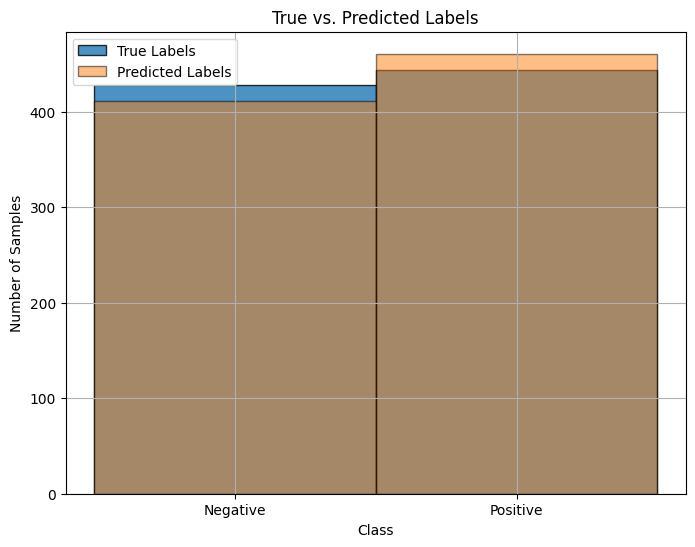

In [57]:
def plot_true_vs_predicted_labels(y_true, y_pred, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(8, 6))
    # True labels histogram
    plt.hist(y_true, bins=np.arange(len(class_names)+1)-0.5, alpha=0.8, label='True Labels', edgecolor='k')
    # Predicted labels histogram
    plt.hist(y_pred, bins=np.arange(len(class_names)+1)-0.5, alpha=0.5, label='Predicted Labels', edgecolor='k')
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('True vs. Predicted Labels')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_true_vs_predicted_labels(validation_labels, validation_preds, class_names=['Negative', 'Positive'])


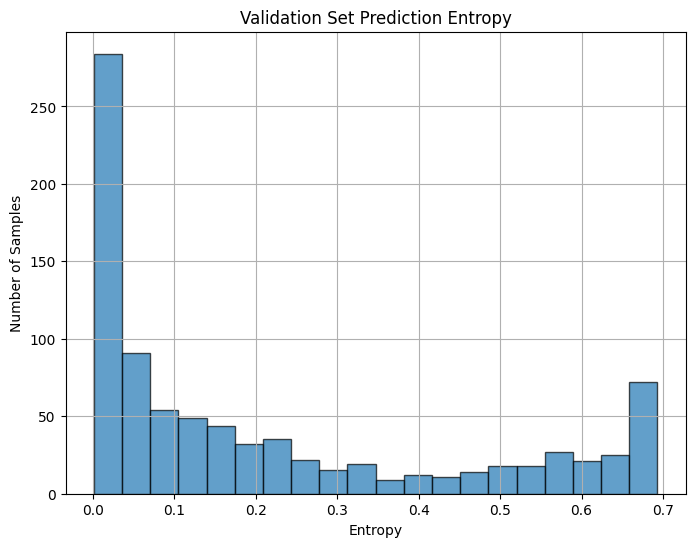

In [58]:
def plot_prediction_entropy(y_probs, title='Prediction Entropy Histogram'):
    from scipy.stats import entropy
    # For binary classification, compute entropy for each sample
    y_probs_2d = np.vstack([1 - y_probs, y_probs]).T  # Shape: (n_samples, 2)
    entropies = entropy(y_probs_2d.T)  # Entropy along the class axis
    plt.figure(figsize=(8, 6))
    plt.hist(entropies, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Entropy')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage
plot_prediction_entropy(validation_probs, title='Validation Set Prediction Entropy')


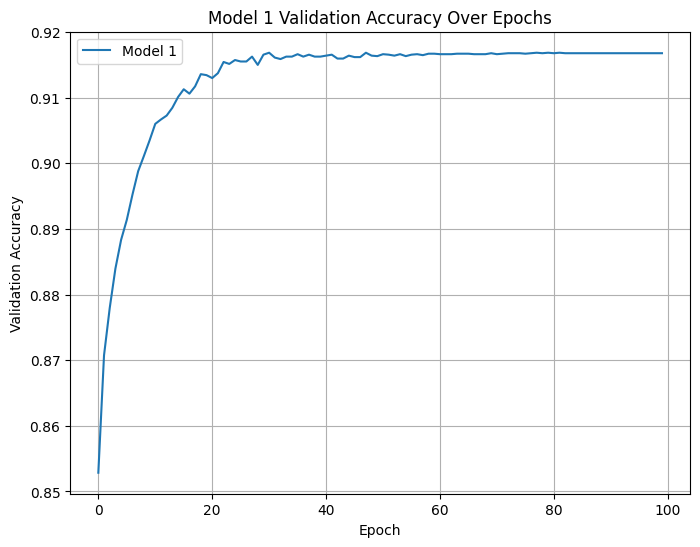

In [59]:
def plot_epoch_wise_validation_accuracy(model_validation_accuracies, model_index):
    plt.figure(figsize=(8, 6))
    plt.plot(model_validation_accuracies, label=f'Model {model_index + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Model {model_index + 1} Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot validation accuracies for the first model
plot_epoch_wise_validation_accuracy(model_validation_accuracies[0], model_index=0)


Ensemble Validation Accuracy with Majority Voting: 86.58%


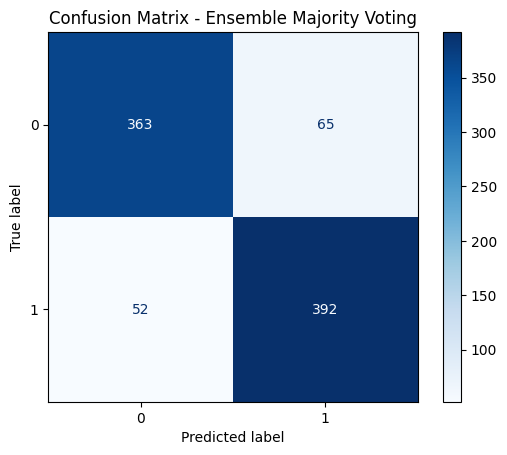

In [93]:
# Function to perform majority voting
def majority_voting(ensemble, embeddings):
    predictions = []
    for model in ensemble:
        model.eval()
        with torch.no_grad():
            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)
            predictions.append(predicted.cpu().numpy())
    # Stack predictions from all models
    predictions = np.stack(predictions, axis=1)
    # Perform majority voting
    from scipy.stats import mode
    majority_votes, _ = mode(predictions, axis=1)
    return majority_votes.flatten()

# Get ensemble predictions using majority voting on validation set
validation_predictions = majority_voting(ensemble, validation_embeddings_tensor)
accuracy = accuracy_score(validation_labels_tensor.cpu().numpy(), validation_predictions)
print(f'Ensemble Validation Accuracy with Majority Voting: {accuracy*100:.2f}%')

# Compute confusion matrix
cm = confusion_matrix(validation_labels_tensor.cpu().numpy(), validation_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Ensemble Majority Voting')
plt.show()

# Distillation

In [7]:
# Define the student model with dropout to capture uncertainty
class StudentModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x  # Logits

# Initialize the student model
student_model = StudentModel(input_dim=embeddings.shape[1], num_classes=2).to(device)

# Define the distillation loss function
def distillation_loss_function(student_outputs, teacher_outputs, true_labels, temperature=1.0, alpha=0.5):
    """
    Compute the distillation loss given student outputs, teacher outputs, and true labels.
    """
    # Convert logits to probabilities with temperature scaling
    student_soft_logits = student_outputs / temperature
    teacher_soft_probs = teacher_outputs  # Already probabilities

    # Compute soft targets: apply softmax with temperature
    student_soft_probs = torch.softmax(student_soft_logits, dim=1)
    # teacher_soft_probs is numpy array, convert to tensor
    teacher_soft_probs = torch.tensor(teacher_soft_probs, dtype=torch.float32).to(device)
    
    # Compute KL divergence loss between student and teacher outputs
    kl_loss = nn.KLDivLoss(reduction='batchmean')(torch.log(student_soft_probs + 1e-9), teacher_soft_probs)
    
    # Compute cross-entropy loss with hard labels
    ce_loss = nn.CrossEntropyLoss()(student_outputs, true_labels)
    
    # Total loss
    loss = alpha * ce_loss + (1 - alpha) * kl_loss * (temperature ** 2)
    return loss


In [8]:
# Function to train the student model
def train_student_model(student_model, embeddings, labels, ensemble_predictions, epochs=100, batch_size=128, temperature=1.0, alpha=0.5):
    student_model.train()
    optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
    dataset_size = embeddings.shape[0]
    indices = np.arange(dataset_size)
    
    # Debugging prints
    print(f"embeddings shape: {embeddings.shape}")
    print(f"labels shape: {labels.shape}")
    print(f"ensemble_predictions shape: {ensemble_predictions.shape}")
    
    # Ensure ensemble_predictions is 2D
    if len(ensemble_predictions.shape) == 1:
        ensemble_predictions = np.expand_dims(ensemble_predictions, axis=1)
    
    num_classes = ensemble_predictions.shape[1]
    print(f"num_classes: {num_classes}")
    
    for epoch in tqdm(range(epochs)):
        np.random.shuffle(indices)
        epoch_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_embeddings = torch.tensor(embeddings[batch_indices], dtype=torch.float32).to(device)
            batch_labels = torch.tensor(labels[batch_indices], dtype=torch.long).to(device)
            batch_teacher_outputs = torch.tensor(ensemble_predictions[batch_indices], dtype=torch.float32).to(device)  # Convert to tensor
            
            optimizer.zero_grad()
            student_outputs = student_model(batch_embeddings)  # logits
            
            loss = distillation_loss_function(student_outputs, batch_teacher_outputs, batch_labels, temperature, alpha)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_embeddings.size(0)
        epoch_loss /= dataset_size
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Train the student model
print("\nTraining the student model with distillation...")
train_student_model(student_model, embeddings, labels, ensemble_predictions, epochs=100, batch_size=32, temperature=1.0, alpha=0.5)



Training the student model with distillation...
embeddings shape: (67349, 2048)
labels shape: (67349,)
ensemble_predictions shape: (67349,)
num_classes: 1


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\wsten\AppData\Local\Temp\ipykernel_87532\1951624959.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  teacher_soft_probs = torch.tensor(teacher_soft_probs, dtype=torch.float32).to(device)
  1%|          | 1/100 [00:05<08:30,  5.16s/it]

Epoch 1/100, Loss: 0.6582


  2%|▏         | 2/100 [00:10<08:18,  5.09s/it]

Epoch 2/100, Loss: 0.6399


  3%|▎         | 3/100 [00:15<08:17,  5.13s/it]

Epoch 3/100, Loss: 0.6330


  4%|▍         | 4/100 [00:20<08:11,  5.12s/it]

Epoch 4/100, Loss: 0.6271


  5%|▌         | 5/100 [00:25<08:12,  5.18s/it]

Epoch 5/100, Loss: 0.6214


  6%|▌         | 6/100 [00:30<07:58,  5.10s/it]

Epoch 6/100, Loss: 0.6182


  7%|▋         | 7/100 [00:35<07:50,  5.06s/it]

Epoch 7/100, Loss: 0.6126


  8%|▊         | 8/100 [00:40<07:44,  5.04s/it]

Epoch 8/100, Loss: 0.6082


  9%|▉         | 9/100 [00:45<07:37,  5.02s/it]

Epoch 9/100, Loss: 0.6053


 10%|█         | 10/100 [00:50<07:30,  5.01s/it]

Epoch 10/100, Loss: 0.6020


 11%|█         | 11/100 [00:55<07:23,  4.99s/it]

Epoch 11/100, Loss: 0.5979


 12%|█▏        | 12/100 [01:00<07:21,  5.02s/it]

Epoch 12/100, Loss: 0.5964


 13%|█▎        | 13/100 [01:05<07:17,  5.03s/it]

Epoch 13/100, Loss: 0.5925


 14%|█▍        | 14/100 [01:10<07:12,  5.03s/it]

Epoch 14/100, Loss: 0.5923


 15%|█▌        | 15/100 [01:15<07:07,  5.03s/it]

Epoch 15/100, Loss: 0.5896


 16%|█▌        | 16/100 [01:20<07:00,  5.00s/it]

Epoch 16/100, Loss: 0.5874


 17%|█▋        | 17/100 [01:25<06:53,  4.98s/it]

Epoch 17/100, Loss: 0.5858


 18%|█▊        | 18/100 [01:30<06:51,  5.02s/it]

Epoch 18/100, Loss: 0.5836


 19%|█▉        | 19/100 [01:35<06:46,  5.02s/it]

Epoch 19/100, Loss: 0.5810


 20%|██        | 20/100 [01:40<06:40,  5.01s/it]

Epoch 20/100, Loss: 0.5819


 21%|██        | 21/100 [01:45<06:38,  5.05s/it]

Epoch 21/100, Loss: 0.5794


 22%|██▏       | 22/100 [01:50<06:32,  5.03s/it]

Epoch 22/100, Loss: 0.5781


 23%|██▎       | 23/100 [01:55<06:26,  5.02s/it]

Epoch 23/100, Loss: 0.5772


 24%|██▍       | 24/100 [02:00<06:18,  4.99s/it]

Epoch 24/100, Loss: 0.5764


 25%|██▌       | 25/100 [02:05<06:12,  4.96s/it]

Epoch 25/100, Loss: 0.5761


 26%|██▌       | 26/100 [02:10<06:06,  4.95s/it]

Epoch 26/100, Loss: 0.5746


 27%|██▋       | 27/100 [02:15<06:00,  4.94s/it]

Epoch 27/100, Loss: 0.5739


 28%|██▊       | 28/100 [02:20<05:55,  4.94s/it]

Epoch 28/100, Loss: 0.5725


 29%|██▉       | 29/100 [02:25<05:49,  4.92s/it]

Epoch 29/100, Loss: 0.5714


 30%|███       | 30/100 [02:30<05:44,  4.92s/it]

Epoch 30/100, Loss: 0.5717


 31%|███       | 31/100 [02:35<05:39,  4.93s/it]

Epoch 31/100, Loss: 0.5706


 32%|███▏      | 32/100 [02:40<05:35,  4.94s/it]

Epoch 32/100, Loss: 0.5706


 33%|███▎      | 33/100 [02:45<05:30,  4.93s/it]

Epoch 33/100, Loss: 0.5700


 34%|███▍      | 34/100 [02:50<05:25,  4.94s/it]

Epoch 34/100, Loss: 0.5691


 35%|███▌      | 35/100 [02:55<05:22,  4.96s/it]

Epoch 35/100, Loss: 0.5683


 36%|███▌      | 36/100 [03:00<05:17,  4.96s/it]

Epoch 36/100, Loss: 0.5685


 37%|███▋      | 37/100 [03:05<05:12,  4.97s/it]

Epoch 37/100, Loss: 0.5680


 38%|███▊      | 38/100 [03:09<05:06,  4.94s/it]

Epoch 38/100, Loss: 0.5658


 39%|███▉      | 39/100 [03:14<05:01,  4.94s/it]

Epoch 39/100, Loss: 0.5666


 40%|████      | 40/100 [03:19<04:57,  4.96s/it]

Epoch 40/100, Loss: 0.5652


 41%|████      | 41/100 [03:24<04:53,  4.97s/it]

Epoch 41/100, Loss: 0.5653


 42%|████▏     | 42/100 [03:29<04:47,  4.96s/it]

Epoch 42/100, Loss: 0.5645


 43%|████▎     | 43/100 [03:34<04:42,  4.95s/it]

Epoch 43/100, Loss: 0.5650


 44%|████▍     | 44/100 [03:39<04:37,  4.96s/it]

Epoch 44/100, Loss: 0.5640


 45%|████▌     | 45/100 [03:44<04:32,  4.95s/it]

Epoch 45/100, Loss: 0.5639


 46%|████▌     | 46/100 [03:49<04:27,  4.95s/it]

Epoch 46/100, Loss: 0.5635


 47%|████▋     | 47/100 [03:54<04:22,  4.95s/it]

Epoch 47/100, Loss: 0.5633


 48%|████▊     | 48/100 [03:59<04:17,  4.95s/it]

Epoch 48/100, Loss: 0.5623


 49%|████▉     | 49/100 [04:04<04:12,  4.95s/it]

Epoch 49/100, Loss: 0.5629


 50%|█████     | 50/100 [04:09<04:06,  4.93s/it]

Epoch 50/100, Loss: 0.5618


 51%|█████     | 51/100 [04:14<04:02,  4.94s/it]

Epoch 51/100, Loss: 0.5614


 52%|█████▏    | 52/100 [04:19<04:00,  5.00s/it]

Epoch 52/100, Loss: 0.5610


 53%|█████▎    | 53/100 [04:24<03:56,  5.03s/it]

Epoch 53/100, Loss: 0.5607


 54%|█████▍    | 54/100 [04:29<03:51,  5.03s/it]

Epoch 54/100, Loss: 0.5601


 55%|█████▌    | 55/100 [04:34<03:46,  5.04s/it]

Epoch 55/100, Loss: 0.5612


 56%|█████▌    | 56/100 [04:39<03:40,  5.02s/it]

Epoch 56/100, Loss: 0.5598


 57%|█████▋    | 57/100 [04:44<03:35,  5.01s/it]

Epoch 57/100, Loss: 0.5605


 58%|█████▊    | 58/100 [04:49<03:29,  4.99s/it]

Epoch 58/100, Loss: 0.5598


 59%|█████▉    | 59/100 [04:54<03:25,  5.00s/it]

Epoch 59/100, Loss: 0.5591


 60%|██████    | 60/100 [04:59<03:20,  5.00s/it]

Epoch 60/100, Loss: 0.5600


 61%|██████    | 61/100 [05:04<03:14,  4.98s/it]

Epoch 61/100, Loss: 0.5596


 62%|██████▏   | 62/100 [05:09<03:09,  4.98s/it]

Epoch 62/100, Loss: 0.5587


 63%|██████▎   | 63/100 [05:14<03:04,  5.00s/it]

Epoch 63/100, Loss: 0.5575


 64%|██████▍   | 64/100 [05:19<03:00,  5.02s/it]

Epoch 64/100, Loss: 0.5568


 65%|██████▌   | 65/100 [05:24<02:56,  5.05s/it]

Epoch 65/100, Loss: 0.5579


 66%|██████▌   | 66/100 [05:29<02:51,  5.04s/it]

Epoch 66/100, Loss: 0.5576


 67%|██████▋   | 67/100 [05:34<02:45,  5.02s/it]

Epoch 67/100, Loss: 0.5577


 68%|██████▊   | 68/100 [05:39<02:40,  5.01s/it]

Epoch 68/100, Loss: 0.5577


 69%|██████▉   | 69/100 [05:44<02:35,  5.02s/it]

Epoch 69/100, Loss: 0.5566


 70%|███████   | 70/100 [05:49<02:30,  5.01s/it]

Epoch 70/100, Loss: 0.5553


 71%|███████   | 71/100 [05:54<02:25,  5.00s/it]

Epoch 71/100, Loss: 0.5566


 72%|███████▏  | 72/100 [05:59<02:19,  5.00s/it]

Epoch 72/100, Loss: 0.5553


 73%|███████▎  | 73/100 [06:04<02:14,  5.00s/it]

Epoch 73/100, Loss: 0.5564


 74%|███████▍  | 74/100 [06:09<02:09,  4.99s/it]

Epoch 74/100, Loss: 0.5563


 75%|███████▌  | 75/100 [06:14<02:04,  4.99s/it]

Epoch 75/100, Loss: 0.5554


 76%|███████▌  | 76/100 [06:19<02:00,  5.00s/it]

Epoch 76/100, Loss: 0.5546


 77%|███████▋  | 77/100 [06:24<01:55,  5.01s/it]

Epoch 77/100, Loss: 0.5550


 78%|███████▊  | 78/100 [06:29<01:50,  5.02s/it]

Epoch 78/100, Loss: 0.5541


 79%|███████▉  | 79/100 [06:34<01:45,  5.01s/it]

Epoch 79/100, Loss: 0.5543


 80%|████████  | 80/100 [06:39<01:40,  5.01s/it]

Epoch 80/100, Loss: 0.5541


 81%|████████  | 81/100 [06:44<01:34,  5.00s/it]

Epoch 81/100, Loss: 0.5538


 82%|████████▏ | 82/100 [06:49<01:29,  5.00s/it]

Epoch 82/100, Loss: 0.5547


 83%|████████▎ | 83/100 [06:54<01:25,  5.00s/it]

Epoch 83/100, Loss: 0.5540


 84%|████████▍ | 84/100 [06:59<01:20,  5.01s/it]

Epoch 84/100, Loss: 0.5529


 85%|████████▌ | 85/100 [07:04<01:14,  4.99s/it]

Epoch 85/100, Loss: 0.5532


 86%|████████▌ | 86/100 [07:09<01:09,  4.98s/it]

Epoch 86/100, Loss: 0.5537


 87%|████████▋ | 87/100 [07:14<01:04,  4.99s/it]

Epoch 87/100, Loss: 0.5527


 88%|████████▊ | 88/100 [07:19<01:00,  5.01s/it]

Epoch 88/100, Loss: 0.5526


 89%|████████▉ | 89/100 [07:24<00:55,  5.01s/it]

Epoch 89/100, Loss: 0.5533


 90%|█████████ | 90/100 [07:29<00:49,  5.00s/it]

Epoch 90/100, Loss: 0.5530


 91%|█████████ | 91/100 [07:35<00:46,  5.14s/it]

Epoch 91/100, Loss: 0.5533


 92%|█████████▏| 92/100 [07:40<00:41,  5.15s/it]

Epoch 92/100, Loss: 0.5531


 93%|█████████▎| 93/100 [07:45<00:35,  5.11s/it]

Epoch 93/100, Loss: 0.5531


 94%|█████████▍| 94/100 [07:50<00:30,  5.07s/it]

Epoch 94/100, Loss: 0.5520


 95%|█████████▌| 95/100 [07:55<00:25,  5.06s/it]

Epoch 95/100, Loss: 0.5517


 96%|█████████▌| 96/100 [08:00<00:20,  5.06s/it]

Epoch 96/100, Loss: 0.5521


 97%|█████████▋| 97/100 [08:05<00:15,  5.06s/it]

Epoch 97/100, Loss: 0.5515


 98%|█████████▊| 98/100 [08:10<00:10,  5.04s/it]

Epoch 98/100, Loss: 0.5520


 99%|█████████▉| 99/100 [08:15<00:05,  5.03s/it]

Epoch 99/100, Loss: 0.5510


100%|██████████| 100/100 [08:20<00:00,  5.00s/it]

Epoch 100/100, Loss: 0.5513


In [9]:
# Function to evaluate the student model
def evaluate_model(model, embeddings, labels, batch_size=128):
    model.eval()
    dataset_size = embeddings.shape[0]
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, dataset_size, batch_size):
            batch_embeddings = embeddings_tensor[i:i+batch_size]
            batch_labels = labels_tensor[i:i+batch_size]
            outputs = model(batch_embeddings)
            probabilities = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(probabilities, dim=1)
            correct += (predicted == batch_labels).sum().item()
            total += batch_labels.size(0)
    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate the student model
print("\nEvaluating the student model...")
accuracy = evaluate_model(student_model, embeddings, labels)



Evaluating the student model...
Accuracy: 98.71%



Getting student predictions with uncertainty estimates...
Ensemble predictive entropy for first few samples: [2.0723267e-08 2.0723267e-08 2.0723267e-08 2.0723267e-08 2.0723267e-08]
Student predictive entropy for first few samples: [0.26634264 0.04752294 0.6358984  0.6465453  0.02644987]
Ensemble predictive entropy mean: 0.0002
Student predictive entropy mean: 0.4028
enemble predictive entropy std: 0.0079
student predictive entropy std: 0.2888


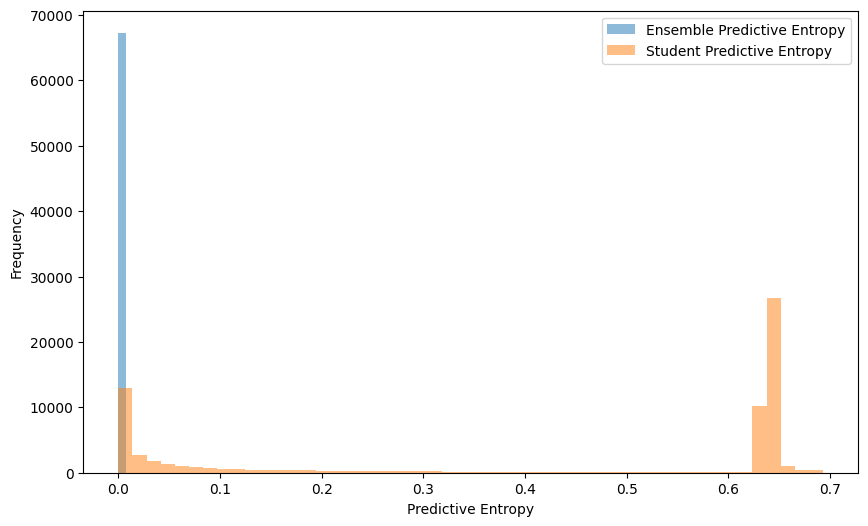

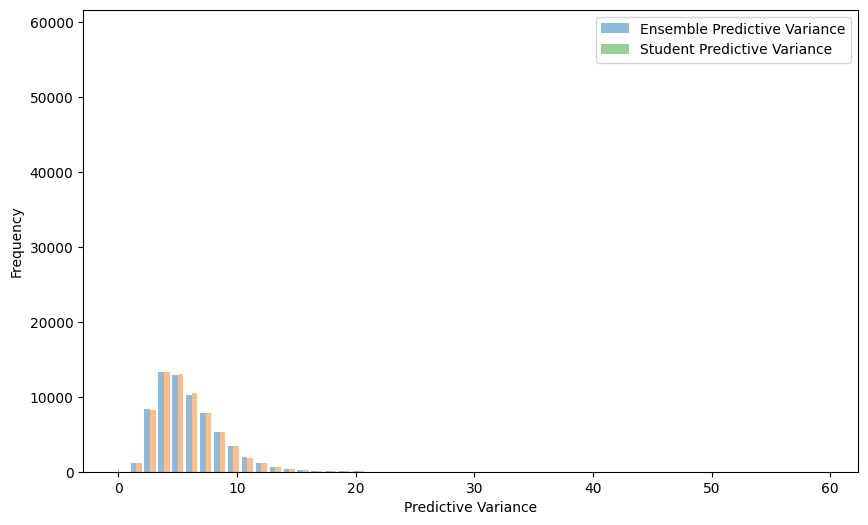

In [10]:
# Function to get student predictions with uncertainty estimates using Monte Carlo Dropout
def get_student_predictions_with_uncertainty(model, embeddings, T=10, batch_size=128):
    model.train()  # Enable dropout
    dataset_size = embeddings.shape[0]
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)
    all_predictions = []
    with torch.no_grad():
        for t in range(T):
            predictions = []
            for i in range(0, dataset_size, batch_size):
                batch_embeddings = embeddings_tensor[i:i+batch_size]
                outputs = model(batch_embeddings)
                probabilities = torch.softmax(outputs, dim=1)
                predictions.append(probabilities.cpu().numpy())
            predictions = np.concatenate(predictions, axis=0)
            all_predictions.append(predictions)
    # Stack predictions: shape (T, num_samples, num_classes)
    all_predictions = np.stack(all_predictions)
    # Compute mean and variance
    mean_predictions = np.mean(all_predictions, axis=0)
    variance_predictions = np.var(all_predictions, axis=0)
    # Compute predictive entropy
    predictive_entropy = -np.sum(mean_predictions * np.log(mean_predictions + 1e-9), axis=1)
    return mean_predictions, variance_predictions, predictive_entropy

# Get student predictions and uncertainties
print("\nGetting student predictions with uncertainty estimates...")
student_mean_predictions, student_variance_predictions, student_entropy = get_student_predictions_with_uncertainty(student_model, embeddings)

# Print predictive uncertainty for the first few samples
print(f'Ensemble predictive entropy for first few samples: {predictive_entropy[:5]}')
print(f'Student predictive entropy for first few samples: {student_entropy[:5]}')
print(f'Ensemble predictive entropy mean: {np.mean(predictive_entropy):.4f}')
print(f'Student predictive entropy mean: {np.mean(student_entropy):.4f}')
print(f'enemble predictive entropy std: {np.std(predictive_entropy):.4f}')
print(f'student predictive entropy std: {np.std(student_entropy):.4f}')

# plot the predictive entropy
plt.figure(figsize=(10, 6))
plt.hist(predictive_entropy, bins=50, alpha=0.5, label='Ensemble Predictive Entropy')
plt.hist(student_entropy, bins=50, alpha=0.5, label='Student Predictive Entropy')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# plot the predictive variance
plt.figure(figsize=(10, 6))
plt.hist(predictive_variance, bins=50, alpha=0.5, label='Ensemble Predictive Variance')
plt.hist(student_variance_predictions, bins=50, alpha=0.5, label='Student Predictive Variance')
plt.xlabel('Predictive Variance')
plt.ylabel('Frequency')
plt.legend()
plt.show()